In [ ]:
!pip3 install optuna

In [ ]:
!pip install git+https://github.com/daviddavo/lightfm

In [ ]:
!pip install tensorboardX

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import glob
import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

python(36194) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/anaconda3/lib/python3.12/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [7]:
# DATA_DIR = "/Users/tatanastelmah/Desktop/"

In [2]:
positives = pd.read_json("positives.json", lines=True)

In [3]:
positives["test"] = np.random.random(len(positives)) >= 0.7
positives.drop_duplicates(["user", "track"], inplace=True)

In [6]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [7]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

In [8]:
len(users), len(tracks)

(10000, 45896)

## Train LightFM

In [12]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

In [13]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [14]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [15]:
def fit_model(
    epochs=1, 
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01, 
    max_sampled=10,
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=3,
    epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
            
        precisions_at.append(np.mean(precision_at))
            
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopiing!")
            break
        
    else:
        if verbose:
            print("No early stopiing happened: increase epochs maybe?")
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [ ]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)
# best_params = study.best_params

In [16]:
best_params = {'loss': 'warp', 'no_components': 140, 'learning_rate': 0.01, 'max_sampled': 60, 'user_alpha': 0.00, 'item_alpha': 0.0001}

In [ ]:
model, precisions_at = fit_model(
    epochs=500,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

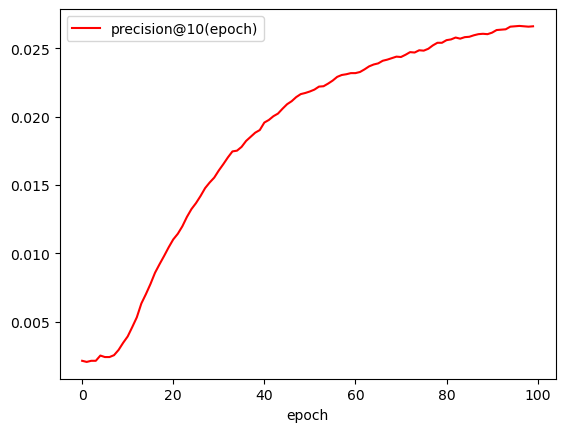

In [25]:
# TODO 1.4: Plot learning curve precision@k(epoch)
figure, ax = pl.subplots()

ax.plot(list(range(len(precisions_at))), precisions_at, "r", label="precision@10(epoch)")

ax.set_xlabel("epoch")
ax.legend()

pass

## Save track embeddings

In [27]:
BOTIFY_DATA_DIR = "/Users/tatanastelmah/Documents/recommend-system-course/recsys-course-spring-2025/botify/data/"

In [28]:
biases, embeddings = model.get_item_representations()

In [29]:
model.item_biases *= 0.0

In [30]:
track_meta = pd.read_json(BOTIFY_DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [33]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [34]:
# writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
# writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
# writer.close()

## Compute top recommendations

In [36]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [37]:
with open(BOTIFY_DATA_DIR + "recommendations_lfm.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-30:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|████████████████████████████████████| 7913/7913 [00:13<00:00, 579.49it/s]
